# Notebook to experiment with training:

https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

## Code:

In [1]:
import wandb
import numpy as np
from gymnasium import spaces
import random
import torch

In [2]:
SEED = 42
# Python RNG
random.seed(SEED)

# NumPy RNG
np.random.seed(SEED)

# PyTorch RNG (CPU + GPU)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [1]:
import sys
sys.path.append("/home/martina/codi2/4year/tfg")  # add parent folder of general.py

from general import prepare, Glioblastoma, Glioblastoma2, testing
from training_dqn import DQN, DQN2, DQN3, DQN4, DQN5
from training_agents import DQNAgent, DQNAgent2
from training_buffers import ReplayBuffer

In [4]:
RUN_NAME = "Extension021"

CURRENT_CONFIG = {
    'grid_size': 4,
    'rewards': [5.0, -1.0, -0.2], 
    'action_space': spaces.Discrete(3)
}

ENVIRONMENT = "Glioblastoma"
NET = "DQN"
AGENT = "DQNAgent"
BUFFER = "ReplayBuffer"

NOTES = "Longer"

LR = 0.0001 #From paper
MEMORY_SIZE = 15000 #From paper
MAX_EPISODES = 200 #From paper

EPSILON = 1.0 #From paper
EPSILON_MIN = 0.1 #From paper
DECAY_TYPE = "exponential"
# DECAY_TYPE = "subtractive"
if DECAY_TYPE == "exponential":
    EPSILON_DECAY = 0.95 #Let's try exponential decay
    print(f"Starting at {EPSILON}, decaying {EPSILON_DECAY} each episode, will reach {EPSILON_MIN} after {int(np.log(EPSILON_MIN/EPSILON)/np.log(EPSILON_DECAY))} episodes")
else:
    EPSILON_DECAY = (EPSILON - EPSILON_MIN) / MAX_EPISODES
    print(f"Starting at {EPSILON}, decaying {EPSILON_DECAY}, will reach {EPSILON_MIN} after {MAX_EPISODES} episodes")


GAMMA = 0.99 #0.99
BATCH_SIZE = 128 #From paper
BURN_IN = 500 # 500
DNN_UPD = 1
DNN_SYNC = 20

Starting at 1.0, decaying 0.95 each episode, will reach 0.1 after 44 episodes


In [5]:
train_pairs = prepare()
env=Glioblastoma(*train_pairs[0], **CURRENT_CONFIG)
print(env.observation_space.shape)
print(env.action_space.n)
print(np.arange(env.action_space.n))

net = DQN(env, learning_rate=LR, device='cpu')
buffer = ReplayBuffer(capacity=MEMORY_SIZE)
agent = DQNAgent(env_config=CURRENT_CONFIG, dnnetwork=net, buffer_class=ReplayBuffer, train_pairs=train_pairs, env_class=Glioblastoma,
                 epsilon=EPSILON, eps_decay=EPSILON_DECAY, eps_decay_type=DECAY_TYPE, epsilon_min=EPSILON_MIN,
                 batch_size=BATCH_SIZE, gamma=GAMMA, 
                 memory_size=MEMORY_SIZE, buffer_initial=BURN_IN,
                 save_name=RUN_NAME)

print(f"Using Glioblastoma class {ENVIRONMENT}, DQN class {NET}, Agent class {AGENT}, Buffer class {BUFFER}")

✅ Found 30 pairs out of 30 listed in CSV.
(60, 60)
3
[0 1 2]
Using Glioblastoma class Glioblastoma, DQN class DQN, Agent class DQNAgent, Buffer class ReplayBuffer


In [6]:
wandb.login()
wandb.Settings(quiet=True)

wandb.init(project="TFG_Glioblastoma",
           name=RUN_NAME,
           id=RUN_NAME,
           config={
            "environment": ENVIRONMENT,
            "configuration": CURRENT_CONFIG,
            "model": NET,
            "agent": AGENT,
            "buffer": BUFFER,
            "notes": NOTES,
            "lr": LR,
            "MEMORY_SIZE": MEMORY_SIZE,
            "MAX_EPISODES": MAX_EPISODES,
            "EPSILON": EPSILON,
            "EPSILON_DECAY": EPSILON_DECAY,
            "Decay type": DECAY_TYPE,
            "EPSILON_MIN": EPSILON_MIN,
            "GAMMA": GAMMA,
            "BATCH_SIZE": BATCH_SIZE,
            "BURN_IN": BURN_IN,
            "DNN_UPD": DNN_UPD,
            "DNN_SYNC": DNN_SYNC, 
})

wandb: Currently logged in as: martinacarrettab to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Filling replay buffer...


Initializing:   0%|          | 0.00/200 [00:00<?, ?ep/s]

Training...
Episode 1 | Episode reward 1.20 | Mean Rewards 1.20 | Epsilon 1.0000 | Loss 2.3091
      Positive rewards: 3, Negative rewards: 17
Episode 2 | Episode reward -4.80 | Mean Rewards -1.80 | Epsilon 0.9500 | Loss 2.7539
      Positive rewards: 2, Negative rewards: 18
Episode 3 | Episode reward -10.00 | Mean Rewards -4.53 | Epsilon 0.9025 | Loss 2.2599
      Positive rewards: 1, Negative rewards: 19
Episode 4 | Episode reward -15.20 | Mean Rewards -7.20 | Epsilon 0.8574 | Loss 2.5666
      Positive rewards: 0, Negative rewards: 20
Episode 5 | Episode reward -4.00 | Mean Rewards -6.56 | Epsilon 0.8145 | Loss 3.4152
      Positive rewards: 2, Negative rewards: 18
Episode 6 | Episode reward 7.20 | Mean Rewards -4.27 | Epsilon 0.7738 | Loss 4.1264
      Positive rewards: 4, Negative rewards: 16
Episode 7 | Episode reward -4.00 | Mean Rewards -4.23 | Epsilon 0.7351 | Loss 6.8216
      Positive rewards: 2, Negative rewards: 18
Episode 8 | Episode reward -4.00 | Mean Rewards -4.20 | Ep

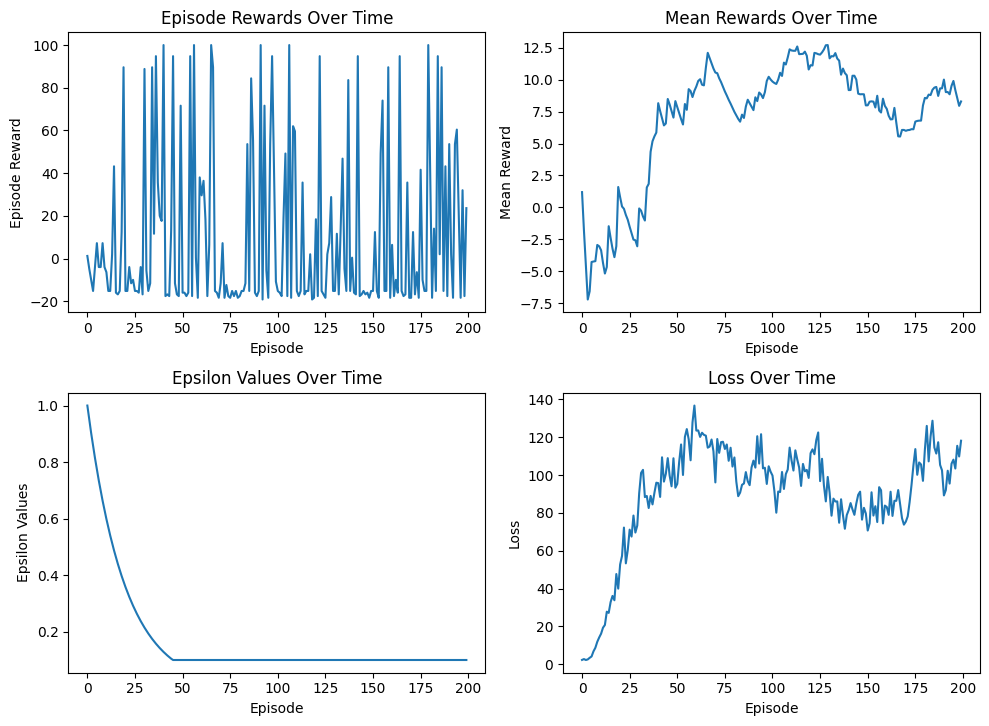

episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
episode reward,▁▂▂▅▇▁▇█▄▃▁█▁▃▁▁▁▁▁▆▁▁▃▄▃▅▁▁▁▁▁▁▇▂▁▁▁█▅▁
epsilon,██▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▁▁▂▂▃▄▅▆▆▅▆▆▆▇▆█▇▇▆▇▆▆▆▇▆▆▆▇▆▆▆▇▇▅▅▅▅▅▆▆
mean_rewards,▁▂▂▃▃▄▃▃▃▃▆▇▆▇▇▆▆▆▇▇▇▇███▇▇███▇▆▇▆▆▅▆▆▇▇
episode,200
episode reward,23.6
epsilon,0.1
loss,118.132
mean_rewards,8.292


In [7]:
agent.train(
    train_pairs=train_pairs,
    gamma=GAMMA,
    max_episodes=MAX_EPISODES,
    dnn_update_frequency=DNN_UPD,
    dnn_sync_frequency=DNN_SYNC
)
wandb.finish()

In [ ]:
wandb.finish()